In [10]:
from astropy.io import fits
from astropy.table import Table, join
import numpy as np
from astropy.stats import sigma_clip
from rs_col_z import rs_col_z

# ============================================================
# 1. LOAD TABLES AND MERGE
# ============================================================

suffix = '20260103185816'

t_hsc_ = Table.read('DESI_DR1_HSCSSP_clean_v2.fits')
t_photo = Table.read('HSC_SSP_zphoto_'+suffix+'.fits')

t_photo = t_photo[['object_id', 'z_photo']]

# selection
z_min = 0.02
z_max = 0.5   # <--- ограничение

t_hsc = t_hsc_[((t_hsc_['z'] > z_min) & (t_hsc_['z'] < z_max) & 
                (t_hsc_['g_kronflux_mag'] > 0) & 
                (t_hsc_['r_kronflux_mag'] > 0) & 
                (t_hsc_['i_kronflux_mag'] > 0) & 
                (t_hsc_['z_kronflux_mag'] > 0) & 
                (t_hsc_['y_kronflux_mag'] > 0) & 
                (t_hsc_['zwarn'] == 0))]

# JOIN
t = join(t_hsc, t_photo, keys='object_id', join_type='inner')
print("Final merged table:", len(t))

# ============================================================
# 2. OBSERVED COLOR AND RED-SEQUENCE COLOR
# ============================================================

obs_color = np.array(t['g_kronflux_mag'] - t['r_kronflux_mag'])
rs_color = np.zeros(len(t))

Final merged table: 1037


In [11]:
def evaluate_in_bins(tbl, Nbins=15, zmin=0.02, zmax=0.5):

    if len(tbl) == 0:
        print("EMPTY TABLE")
        return None

    z_spec  = np.array(tbl["z"])
    z_phot  = np.array(tbl["z_photo"])
    obs_col = np.array(tbl["g_kronflux_mag"] - tbl["r_kronflux_mag"])

    # red-sequence color for each object
    rs_col = np.zeros(len(tbl))
    for i in range(len(tbl)):
        mg = tbl["g_kronflux_mag"][i]
        z  = tbl["z"][i]
        #rs_col[i] = rs_col_z(mg, 'g', 'g - r', z)

    dz = z_phot - z_spec
    norm_dz = dz / (1 + z_spec)

    # ------- BINNING IN REDSHIFT -------
    bins = np.linspace(zmin, zmax, Nbins + 1)
    print(bins)
    indices = np.digitize(z_spec, bins)

    # store per-bin results
    results = dict(
        zmean=[], z_lo=[], z_hi=[],
        red_bias=[], red_scatter=[], red_N=[],
        blue_bias=[], blue_scatter=[], blue_N=[]
    )

    # ------- PROCESS EACH z-BIN -------
    for i in range(1, Nbins + 1):
        bin_mask = indices == i
        if not np.any(bin_mask):
            # empty bin
            results["z_lo"].append(np.nan)
            results["z_hi"].append(np.nan)
            results["zmean"].append(np.nan)
            results["red_bias"].append(np.nan)
            results["red_scatter"].append(np.nan)
            results["red_N"].append(0)
            results["blue_bias"].append(np.nan)
            results["blue_scatter"].append(np.nan)
            results["blue_N"].append(0)
            continue

        # data inside this z-bin
        z_bin     = z_spec[bin_mask]
        dz_bin    = norm_dz[bin_mask]
        obs_bin   = obs_col[bin_mask]
        rs_bin    = rs_col_z(20.0, 'g', 'g - r', np.mean(z_bin))

        # ------- SPLIT INTO RED / BLUE WITHIN THIS BIN -------
        mask_red  = obs_bin > (rs_bin - 0.15)
        mask_blue = obs_bin < (rs_bin - 0.15)

        # compute per-subset stats
        def compute_subset_stats(mask):
            if np.sum(mask) == 0:
                return np.nan, np.nan, 0
            sub = dz_bin[mask]

            # remove catastrophic outliers
            noncat = np.abs(sub) < 0.3
            sub = sub[noncat]

            clipped = sigma_clip(sub, sigma=2.5, maxiters=10, cenfunc='mean')
            mean_bias = np.mean(clipped.data[~clipped.mask])
            scatter   = np.std(clipped.data[~clipped.mask])
            return mean_bias, scatter, np.sum(mask)

        # red subset
        red_bias, red_scatter, red_N = compute_subset_stats(mask_red)

        # blue subset
        blue_bias, blue_scatter, blue_N = compute_subset_stats(mask_blue)

        # store results
        results["z_lo"].append(bins[i-1])
        results["z_hi"].append(bins[i])
        results["zmean"].append(np.mean(z_bin))
        results["red_bias"].append(red_bias)
        results["red_scatter"].append(red_scatter)
        results["red_N"].append(red_N)
        results["blue_bias"].append(blue_bias)
        results["blue_scatter"].append(blue_scatter)
        results["blue_N"].append(blue_N)

        print(f"z-bin {i:2d}  z~{np.mean(z_bin):.3f}  | "
              f"RED  N={red_N:5d} bias={red_bias:.4f} σ={red_scatter:.4f}   || "
              f"BLUE N={blue_N:5d} bias={blue_bias:.4f} σ={blue_scatter:.4f}")

    # convert to arrays
    for k in results:
        results[k] = np.array(results[k])

    return results

In [12]:
res = evaluate_in_bins(t, Nbins=12, zmin=0.02, zmax=0.5)

[0.02 0.06 0.1  0.14 0.18 0.22 0.26 0.3  0.34 0.38 0.42 0.46 0.5 ]
z-bin  1  z~0.042  | RED  N=   20 bias=0.0923 σ=0.1081   || BLUE N=   36 bias=0.0298 σ=0.1022
z-bin  2  z~0.081  | RED  N=   19 bias=0.1153 σ=0.0873   || BLUE N=   41 bias=-0.0946 σ=0.0769
z-bin  3  z~0.125  | RED  N=   25 bias=0.1281 σ=0.0544   || BLUE N=   53 bias=-0.0254 σ=0.1150
z-bin  4  z~0.159  | RED  N=   37 bias=0.1101 σ=0.0428   || BLUE N=   85 bias=0.0275 σ=0.0919
z-bin  5  z~0.199  | RED  N=   37 bias=0.1072 σ=0.0554   || BLUE N=   93 bias=0.0520 σ=0.0650
z-bin  6  z~0.243  | RED  N=   19 bias=0.0778 σ=0.0308   || BLUE N=  101 bias=0.0355 σ=0.0570
z-bin  7  z~0.281  | RED  N=    8 bias=0.0059 σ=0.0784   || BLUE N=  141 bias=0.0378 σ=0.0565
z-bin  8  z~0.320  | RED  N=    6 bias=0.0842 σ=0.0398   || BLUE N=  103 bias=0.0313 σ=0.0617
z-bin  9  z~0.360  | RED  N=    7 bias=0.0439 σ=0.0606   || BLUE N=   78 bias=0.0030 σ=0.0623
z-bin 10  z~0.399  | RED  N=    5 bias=0.0480 σ=0.0497   || BLUE N=   50 bias=-0.0031

In [13]:
from astropy.table import Table
import numpy as np

def save_bin_results(results, prefix="photoz"):
    """
    results — словарь, который возвращает evaluate_in_bins()
    prefix  — базовое имя файла (будет добавлен _red / _blue)
    """

    # ----- RED TABLE -----
    t_red = Table()
    t_red["z_mean"]  = results["zmean"]
    t_red["z_lo"]    = results["z_lo"]
    t_red["z_hi"]    = results["z_hi"]
    t_red["bias"]    = results["red_bias"]
    t_red["scatter"] = results["red_scatter"]
    t_red["N"]       = results["red_N"]

    red_filename = f"{prefix}_red_bins_{suffix}.csv"
    t_red.write(red_filename, overwrite=True)
    print(f"Saved red-galaxy bin stats → {red_filename}")

    # ----- BLUE TABLE -----
    t_blue = Table()
    t_blue["z_mean"]  = results["zmean"]
    t_blue["z_lo"]     = results["z_lo"]
    t_blue["z_hi"]     = results["z_hi"]
    t_blue["bias"]    = results["blue_bias"]
    t_blue["scatter"] = results["blue_scatter"]
    t_blue["N"]       = results["blue_N"]

    blue_filename = f"{prefix}_blue_bins_{suffix}.csv"
    t_blue.write(blue_filename, overwrite=True)
    print(f"Saved blue-galaxy bin stats → {blue_filename}")

    return t_red, t_blue

In [14]:
print(res)

t_red_bins, t_blue_bins = save_bin_results(res, prefix="photoz_stat")

{'zmean': array([0.04166511, 0.08063721, 0.12534948, 0.15916731, 0.19863789,
       0.24274326, 0.28134252, 0.3201814 , 0.3602235 , 0.39889114,
       0.43884609, 0.48211966]), 'z_lo': array([0.02, 0.06, 0.1 , 0.14, 0.18, 0.22, 0.26, 0.3 , 0.34, 0.38, 0.42,
       0.46]), 'z_hi': array([0.06, 0.1 , 0.14, 0.18, 0.22, 0.26, 0.3 , 0.34, 0.38, 0.42, 0.46,
       0.5 ]), 'red_bias': array([0.09232522, 0.11534911, 0.12809236, 0.1100907 , 0.10719868,
       0.07783706, 0.00586112, 0.08421524, 0.04385645, 0.04804846,
       0.00039299, 0.04642554]), 'red_scatter': array([0.10807305, 0.0873201 , 0.05440972, 0.04282206, 0.05539189,
       0.03076103, 0.07839059, 0.03976036, 0.06064622, 0.04972481,
       0.05423297, 0.01777147]), 'red_N': array([20, 19, 25, 37, 37, 19,  8,  6,  7,  5,  5,  9]), 'blue_bias': array([ 0.02980605, -0.09456492, -0.02543132,  0.02754396,  0.05196985,
        0.03548195,  0.03776338,  0.03128191,  0.00296982, -0.00310083,
       -0.05142384, -0.0690935 ]), 'blue_scatte

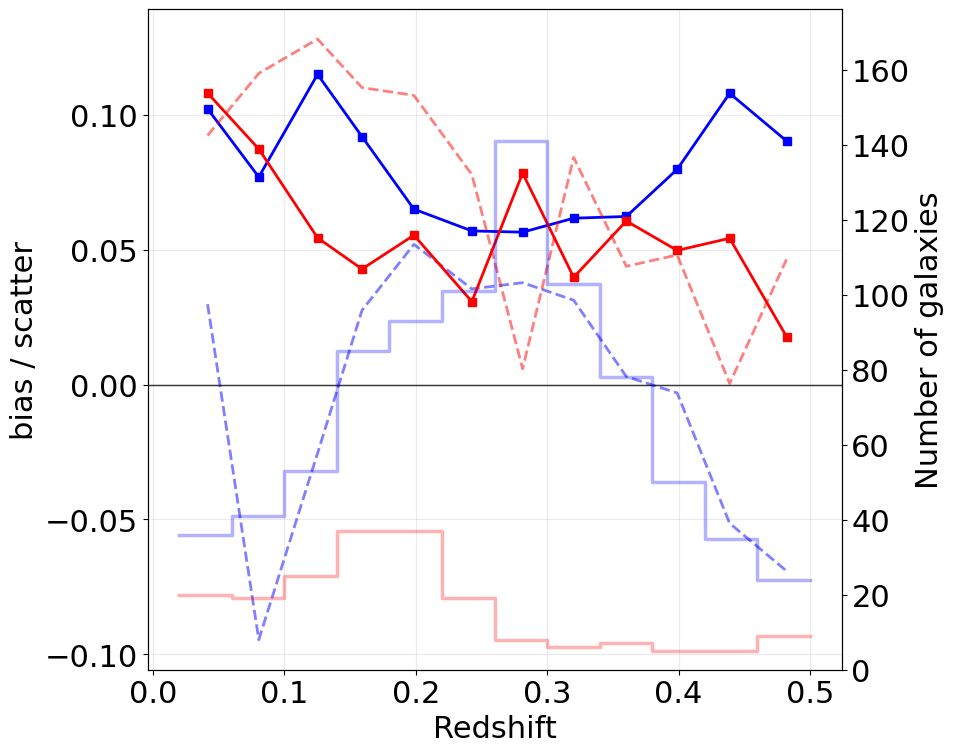

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import matplotlib

matplotlib.rcParams.update({'font.size': 22})


# ---------------------------------------------------------
# Load table
# ---------------------------------------------------------
tbl = Table.read(f"photoz_stat_blue_bins_{suffix}.csv")   # или твой путь

z_mean  = np.array(tbl["z_mean"])
z_lo    = np.array(tbl["z_lo"])
z_hi    = np.array(tbl["z_hi"])
bias    = np.array(tbl["bias"])
scatter = np.array(tbl["scatter"])
N       = np.array(tbl["N"])

# ширина бинов для визуализации фона
bin_width = z_hi - z_lo
bin_cen = 0.5*(z_hi + z_lo)

# ---------------------------------------------------------
# Plot
# ---------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 8))

# ---- background: N (right y-axis) ----
ax2 = ax1.twinx()

x_step = np.ravel(np.column_stack([z_lo, z_hi]))
y_step = np.ravel(np.column_stack([N,    N]))

ax2.step(
    x_step,
    y_step,
    where="post",
    color="blue",
    alpha=0.3,
    linewidth=2.5,
    label="N galaxies",
    zorder=-32
)

ax2.set_ylim(0, max(N) * 1.25)

# ---- main curves: bias + scatter ----
ax1.plot(z_mean, bias, linestyle="--", alpha=0.5, linewidth=2, label="bias", color='blue')
ax1.plot(z_mean, scatter, marker="s", linestyle="-", linewidth=2, label="scatter", color='blue')

ax1.axhline(0, color="black", linewidth=1, alpha=0.5)

# ---- improve look ----
ax1.grid(alpha=0.25)
#ax1.legend(loc="upper left")
#ax2.legend(loc="upper right")

tbl = Table.read(f"photoz_stat_red_bins_{suffix}.csv")   # или твой путь

z_mean  = np.array(tbl["z_mean"])
z_lo    = np.array(tbl["z_lo"])
z_hi    = np.array(tbl["z_hi"])
bias    = np.array(tbl["bias"])
scatter = np.array(tbl["scatter"])
N       = np.array(tbl["N"])

# ширина бинов для визуализации фона
bin_width = z_hi - z_lo
bin_cen = 0.5*(z_hi + z_lo)

# ---------------------------------------------------------
# Plot
# ---------------------------------------------------------

# ---- background: N (right y-axis) ----
x_step = np.ravel(np.column_stack([z_lo, z_hi]))
y_step = np.ravel(np.column_stack([N,    N]))

ax2.step(
    x_step,
    y_step,
    where="post",
    color="red",
    alpha=0.3,
    linewidth=2.5,
    label="N galaxies",
    zorder=-32
)

ax2.set_ylabel("Number of galaxies")

# ---- main curves: bias + scatter ----
ax1.plot(z_mean, bias, linestyle="--", alpha=0.5, linewidth=2, label="bias", color='red')
ax1.plot(z_mean, scatter, marker="s", linestyle="-", linewidth=2, label="scatter", color='red')

ax1.set_xlabel("Redshift")
ax1.set_ylabel("bias / scatter")
ax1.axhline(0, color="black", linewidth=1, alpha=0.5)

# ---- improve look ----
ax1.grid(alpha=0.25)
#ax1.legend(loc="upper left")
#ax2.legend(loc="upper right")

plt.tight_layout()
plt.savefig(f'dz_red_blue_{suffix}.pdf')
plt.show()


